In [4]:
import os
import pandas as pd
import numpy as np
import json
import folium
from IPython.display import display, HTML
from ipywidgets import widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import branca.colormap as cm
from matplotlib import colors
import seaborn as sns
sns.set()

In [2]:
df_refugee = pd.read_csv("time_series.csv",low_memory=False)
display(df_refugee.size)
df_refugee['Value'] = pd.to_numeric(df_refugee['Value'], errors='coerce')
df_refugee= df_refugee[df_refugee['Value'] > 0]
df_refugee = df_refugee[df_refugee['Year']>1984]
display(df_refugee.shape)
df_refugee = df_refugee.groupby(['Year','Country / territory of asylum/residence','Origin']).sum().reset_index()
df_refugee = df_refugee.rename(columns={"Year":"year","Value":"value"})
display(df_refugee.shape)

1492205

(161831, 5)

(111300, 4)

In [23]:
df_geo  = pd.read_csv("geo.csv",na_values ='NaN',keep_default_na =False)
df_merge = df_refugee.merge(df_geo, left_on='Country / territory of asylum/residence', right_on='name', how='inner')
df_merge = df_merge[['year','value','Origin',"country"]]
df_merge = df_merge.rename(columns={"country" : "country_asylum"})
df_merge = df_merge.merge(df_geo, left_on='Origin', right_on='name', how='inner')

df_merge = df_merge[['year',"country","country_asylum",'value']]
df_merge = df_merge.rename(columns={"country":"country_origin"})

df_merge = df_merge[df_merge['country_asylum']!=df_merge['country_origin']]

df_merge = df_merge.sort_values("year")

display(df_merge.head())

year country_origin country_asylum   value
0      1985             CL             DZ   100.0
60912  1985             UY             CU   400.0
60844  1985             UY             AR  1220.0
85203  1985             DO             IT     1.0
72612  1985             GH             CI   220.0

In [24]:
df_immigration_exit = df_merge.drop("country_asylum",1)
df_immigration_exit = df_immigration_exit.groupby(["year","country_origin"]).sum().reset_index()
df_immigration_exit= df_immigration_exit.sort_values(["country_origin","year"])
display(df_immigration_exit.head())
df_immigration_exit.to_csv("data_immigration_exit.csv", sep=',', encoding='utf-8',index = False)

year country_origin  value
893   1994             AD    2.0
1060  1995             AD    2.0
1232  1996             AD    3.0
1409  1997             AD    1.0
1588  1998             AD    2.0

In [25]:
df_immigration_entry = df_merge.drop("country_origin",1)
df_immigration_entry = df_immigration_entry.groupby(["year","country_asylum"]).sum().reset_index()
df_immigration_entry= df_immigration_entry.sort_values(["country_asylum","year"])
df_immigration_entry = df_immigration_entry[["country_asylum","year","value"]]
display(df_immigration_entry.head())
df_immigration_entry.to_csv("data_immigration_entry.csv", sep=',', encoding='utf-8',index = False)

country_asylum  year   value
0                AE  1985  6350.0
619              AE  1993   427.0
751              AE  1994   474.0
882              AE  1995   404.0
1016             AE  1996   450.0

In [26]:
import math
def keepNonNan(country_origin,country_asylum):
    if (country_origin == 0):
        return country_asylum
    if (country_asylum == 0):
        return country_origin 
    return country_origin

In [27]:
df_immigration_delta = df_immigration_entry.merge(df_immigration_exit,right_on=['year','country_origin'], left_on=['year','country_asylum'], how='outer')
df_immigration_delta = df_immigration_delta.fillna(0)
df_immigration_delta['country'] = df_immigration_delta.apply(lambda x:keepNonNan(x['country_origin'],x['country_asylum']),axis = 1)

df_immigration_delta = df_immigration_delta[df_immigration_delta.country != 0]
df_immigration_delta['value'] = df_immigration_delta.value_x - df_immigration_delta.value_y

df_immigration_delta = df_immigration_delta[["year","country","value"]]
df_immigration_delta = df_immigration_delta.sort_values(["year","country"])
display(df_immigration_delta.head())

year country      value
0     1985      AE     6350.0
4328  1985      AF -4654343.0
4353  1985      AL    -3067.0
4360  1985      AM     -333.0
104   1985      AO  -226502.0

In [45]:
print(np.linspace(0.09,1,10, endpoint=False))

[ 0.09   0.181  0.272  0.363  0.454  0.545  0.636  0.727  0.818  0.909]


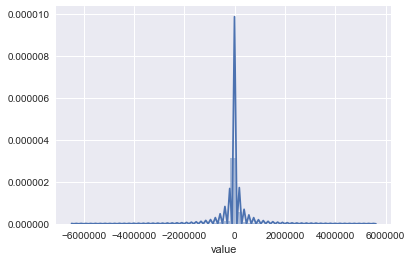

array([-116915.,  -15082.,   -1632.,    -114.,      -5.,     119.,
          2414.,    9802.,   43690.,  164085.])

In [49]:
sns.distplot(df_immigration_delta.value)
plt.show()
np.set_printoptions(suppress=True)
df_immigration_delta.value.quantile(np.linspace(0.09,1,10, endpoint=False), interpolation='nearest').values

In [8]:
df_immigration_delta.to_csv("data_immigration_delta.csv", sep=',', encoding='utf-8',index = False)